# Red convolucional preentrenada

En esta práctica vamos a analizar otro de los ficheros pregargados que hay en Keras, un conjunto de imágenes de ropa llamdo fashion-mnist. Tienes una descripción de los datos en este [enlace](https://keras.io/api/datasets/fashion_mnist/).

Las imágenes pertenecen a 10 categorías de ropa, clasificadas con un número del 0 al 9. Un ejemplo de la imágenes:
![Conjunto MNIST](https://www.tensorflow.org/tutorials/keras/classification_files/output_oZTImqg_CaW1_0.png?hl=es-419)

Para analizar estos datos vamos a usar una red preentrenada la VGG16, es una red del 2015 y aunque no es de las más potentes comparada con las más modernas funciona bastante bien. Tiene unos 15 millones de parámetros y mezcla bloques con capas de convolución y pooling. Puedes encontrar más información en la página de keras dedicada a la red ([enlace](https://keras.io/api/applications/vgg/)).

Los datos son similares a mnist, imágenes de 28x28 en escala de grises y VGG16 solo acepta imágenes de al menos 32x32 y en formato RGB por lo que habrá que hacer un preprocesamiento. Como la ejecución es muy demandante vamos a crear un conjunto reducido de solo 100 imágenes para hacer las pruebas y luego el alumno puede intentar ejecutarlo con todo el set completo.

Vamos a cargar solo parte de la red, las capas inferiores dedicadas a la extracción de rasgos y luego añadiremos nuestras capas que sí vamos a entrenar para que haga bien la tarea de clasificación.

Muchas de las cosas que se utilizan están ya vistas en otras prácticas con lo que aparecerán solo mencionadas.





In [1]:
# Importamos librerías

import tensorflow as tf
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import time

from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense


2024-03-12 00:05:46.148094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# definimos la función para visualizar la historia

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_loss'],'b',
           label = 'Validation Error')
  # plt.ylim([0,20])
  plt.legend()
  plt.show()

4422102/4422102 [==============================] - 0s 0us/step


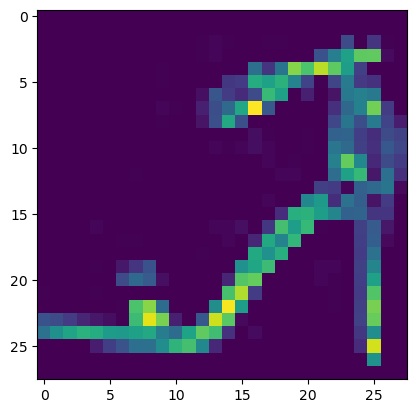

In [3]:
# importamos los datos desde keras

data = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = data.load_data()

# visualizamos la imagen 8
plt.imshow(x_train[8])
plt.show()

In [5]:
# Preprocesamiento -------------------

# seleccionamos 100 imagenes para probar
idx = np.random.randint(60000, size=100)
x_train_small = x_train[idx,:,:]
y_train_small = y_train[idx]

# expandimos las imagenes a 32x32 y con una dimension más que va a ser el color
x_train_small = np.expand_dims(x_train_small, axis=-1)
x_train_small = tf.image.resize(x_train_small, [32,32]) # if we want to resize

# Pasamos la escala de grises a RGB
x_train_small=tf.image.grayscale_to_rgb(x_train_small)

# Normalizamos para que los valores vayan de 0 a 1
x_train_small = x_train_small/255.

# comprobamos que las dimensiones son correctas
print(x_train_small.shape)

(100, 32, 32, 3)


Ahora se carga la red preentrenada, es tan sencillo como el siguiente código:



```
pre_trained_model = VGG16(input_shape = (32, 32, 3),
                          include_top = False,
                          weights = 'imagenet')
```
Le estamos indicando que vamos a introducir imágenes de 32x32x3 y que solo incluya las capas inferiores. El último parámetro especifica que se utilice la confifuración dada con imagenet.


In [6]:
pre_trained_model = VGG16(input_shape = (32, 32, 3),
                          include_top = False,
                          weights = 'imagenet')

pre_trained_model.summary()

58889256/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

Fíjate que la red contiene casi 15 millones de parámetros, ahora le tenemos que decir que son no entrenables, es decir, que no cambien los valores que tienen ya los pesos

In [7]:
for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

Mira como Trainable params ha pasado de 14 millones a 0, ahora nada de esta red se va a modificar.

Tenemos que añadir las capas que se van a encargar de la clasificación

In [13]:
# creamos nuestro modelo incluyendo el pre_trained

model = Sequential()
model.add(pre_trained_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 14848586 (56.64 MB)
Trainable params: 133898 (523.04 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [14]:
# compilamos con los parametros habituales

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'])

In [15]:
# Aprendizaje

# FIT     ----------------------------------------------------------------
start = time.time()
history = model.fit(x_train_small, y_train_small,
              batch_size=10,
              epochs=30,
              validation_split = 0.2,
              verbose=0)
end = time.time()
print('Tiempo de ejecución:', end - start)


Tiempo de ejecución: 11.378324031829834


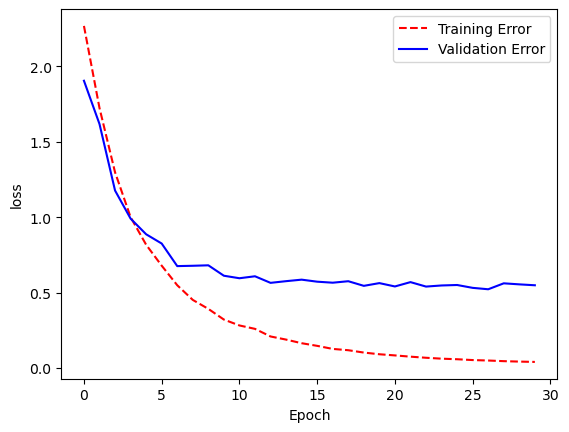

4/4 [==============================] - 1s 75ms/step - loss: 0.1394 - accuracy: 0.9500
Test accuracy: 0.949999988079071


In [16]:
# Evaluacion

plot_history(history)

test_loss, test_acc = model.evaluate(x_train_small, y_train_small)
print('Test accuracy:', test_acc)

# Ejercicio


Ajusta los parametros de clasificacion de la red con el grupo de imagenes pequeño x_train_small y cuando creas que funciona razonablemente bien pasa a calcular la red con todos los datos

Fíjate que no hemos preprocesado ni los datos de x_test ni ninguno de los que pertenecen al conjunto de test

Cuando tengas tu red lista sube los comentarios y la parte del codigo que consideres interesante a moodle

